<a href="https://colab.research.google.com/github/pawanraje16/CVDLlab/blob/main/CvdlPro2_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d aryashah2k/mango-leaf-disease-dataset

Dataset URL: https://www.kaggle.com/datasets/aryashah2k/mango-leaf-disease-dataset
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)


In [ ]:
import zipfile

with zipfile.ZipFile("mango-leaf-disease-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("data")

In [ ]:
!pip install torch torchvision matplotlib tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import os
import cv2
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image

class MangoLeafDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.images = []
        self.labels = []
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))

        for idx, disease in enumerate(self.classes):
            path = os.path.join(root_dir, disease)
            for img_file in os.listdir(path):
                img_path = os.path.join(path, img_file)
                self.images.append(img_path)
                self.labels.append(idx)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # Normalize to [-1, 1]
])

dataset = MangoLeafDataset("data", transform=transform)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, latent_dim=100):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(128*16*16, latent_dim)
        self.fc_logvar = nn.Linear(128*16*16, latent_dim)
        self.decoder_input = nn.Linear(latent_dim, 128*16*16)

        self.decoder = nn.Sequential(
            nn.Unflatten(1, (128, 16, 16)),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1), nn.Tanh()
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder_input(z)
        return self.decoder(x)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 512, 4, 1, 0), nn.BatchNorm2d(512), nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128, 3, 4, 2, 1), nn.Tanh()
        )

    def forward(self, z):
        return self.gen(z)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1, 4, 1, 0), nn.Sigmoid()
        )

    def forward(self, x):
        return self.disc(x).view(-1)


In [ ]:
from torch.utils.data import DataLoader
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE(latent_dim=100).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

def vae_loss_function(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# === Train VAE ===
for epoch in range(1, 100):
    vae.train()
    total_loss = 0
    for batch, _ in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = vae(batch)
        loss = vae_loss_function(recon, batch, mu, logvar)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
    print(f"[VAE] Epoch {epoch}, Loss: {total_loss / len(dataloader.dataset):.4f}")



[VAE] Epoch 1, Loss: 1975.6576
[VAE] Epoch 2, Loss: 740.4727
[VAE] Epoch 3, Loss: 576.7395
[VAE] Epoch 4, Loss: 506.1073
[VAE] Epoch 5, Loss: 456.0030
[VAE] Epoch 6, Loss: 424.4422
[VAE] Epoch 7, Loss: 399.8127
[VAE] Epoch 8, Loss: 379.1655
[VAE] Epoch 9, Loss: 359.6547
[VAE] Epoch 10, Loss: 346.8016
[VAE] Epoch 11, Loss: 337.6822
[VAE] Epoch 12, Loss: 324.2686
[VAE] Epoch 13, Loss: 318.8859
[VAE] Epoch 14, Loss: 312.9892
[VAE] Epoch 15, Loss: 305.4789
[VAE] Epoch 16, Loss: 300.6150
[VAE] Epoch 17, Loss: 295.9219
[VAE] Epoch 18, Loss: 295.3047
[VAE] Epoch 19, Loss: 289.5570
[VAE] Epoch 20, Loss: 284.0741
[VAE] Epoch 21, Loss: 281.2803
[VAE] Epoch 22, Loss: 277.9427
[VAE] Epoch 23, Loss: 276.0525
[VAE] Epoch 24, Loss: 275.4827
[VAE] Epoch 25, Loss: 269.0168
[VAE] Epoch 26, Loss: 266.8641
[VAE] Epoch 27, Loss: 264.1840
[VAE] Epoch 28, Loss: 262.2123
[VAE] Epoch 29, Loss: 260.4703
[VAE] Epoch 30, Loss: 259.9331
[VAE] Epoch 31, Loss: 255.7021
[VAE] Epoch 32, Loss: 256.1801
[VAE] Epoch 33, 

In [ ]:
import torchvision.utils as vutils

# For VAE
vae.eval()
with torch.no_grad():
    z = torch.randn(10, 100).to(device)
    samples = vae.decode(z).cpu()
    vutils.save_image(samples, "vae_samples.png", nrow=10, normalize=True)

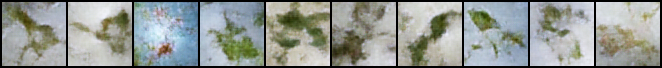

In [ ]:
from IPython.display import Image, display

display(Image("vae_samples.png"))



In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 512, 4, 1, 0), nn.BatchNorm2d(512), nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128, 3, 4, 2, 1), nn.Tanh()
        )

    def forward(self, z):
        return self.gen(z)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1, 4, 1, 0), nn.Sigmoid()
        )

    def forward(self, x):
        return self.disc(x).view(-1)


In [ ]:
from torchvision.utils import save_image
import torch.nn as nn
import os
import torch
from torch.utils.data import Dataset
from PIL import Image  # ✅ This line is essential



generator = Generator(z_dim=100).to(device)
discriminator = Discriminator().to(device)

optim_G = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
optim_D = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

criterion = nn.BCELoss()

# === Train DCGAN ===
for epoch in range(1, 51):
    for real, _ in dataloader:
        real = real.to(device)
        batch_size = real.size(0)

        # === Train Discriminator ===
        z = torch.randn(batch_size, 100, 1, 1).to(device)
        fake = generator(z)

        real_labels = torch.ones(batch_size, device=device)
        fake_labels = torch.zeros(batch_size, device=device)

        optim_D.zero_grad()
        pred_real = discriminator(real)
        pred_fake = discriminator(fake.detach())
        loss_D = criterion(pred_real, real_labels) + criterion(pred_fake, fake_labels)
        loss_D.backward()
        optim_D.step()

        # === Train Generator ===
        optim_G.zero_grad()
        pred_fake = discriminator(fake)
        loss_G = criterion(pred_fake, real_labels)
        loss_G.backward()
        optim_G.step()

    print(f"[GAN] Epoch {epoch} | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")

    # Save sample grid
    if epoch % 10 == 0:
        with torch.no_grad():
            z = torch.randn(64, 100, 1, 1).to(device)
            samples = generator(z)
            save_image(samples, f"gan_samples_epoch{epoch}.png", normalize=True, nrow=8)


ValueError: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([1600])) is deprecated. Please ensure they have the same size.